In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True,with_l4=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
from sklearn.linear_model import Ridge

In [10]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [11]:
lag_cols=['weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0', 'const_one', 'visitors', 'geo1_visitors_mean', 'geo2_visitors_mean', 'station_visitors_mean', 'genre_name_visitors_mean', 'day_of_week_visitors_mean', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'visitor_ma2', 'visitor_ma4', 'visitor_ma7', 'visitor_ma14', 'visitor_ma28', 'visitor_ma56', 'visitor_ma112', 'visitor_ma224', 'visitor_sma1', 'visitor_sma2', 'visitor_sma3', 'visitor_sma4', 'visitor_sma8', 'visitor_sma16', 'visitor_sma32', 'visitors_minus_ma28', 'visitors_divid_ma28', 'all_count_y1', 'geo1_count_y1', 'station_count_y1', 'geo2_count_y1', 'all_count_y2', 'geo1_count_y2', 'station_count_y2', 'geo2_count_y2', 'all_count_y3', 'geo1_count_y3', 'station_count_y3', 'geo2_count_y3', 'all_count_y4', 'geo1_count_y4', 'station_count_y4', 'geo2_count_y4', 'all_count_y5', 'geo1_count_y5', 'station_count_y5', 'geo2_count_y5', 'TMAX', 'TMIN', 'TAVG', 'PRCP', 'holiday', 's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio', 'f_t', 'bad_ratio', 'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean']
len(lag_cols)

72

In [12]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [13]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                        ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl',
                    'l3_3000_ridge_fold{}_False_d478.pkl', 'l3_3003_conv_fold{}_False_d478.pkl', 'l3_3006_xgb_fold{}_False_d478.pkl', 'l3_3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [14]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [15]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [16]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [17]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [18]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        gbm = Ridge(alpha=3)
        gbm.fit(trainX,trainy)

        models.append(gbm)
        validpred=gbm.predict(validX)
        scores.append(mean_squared_error(validy,validpred))
        print mean_squared_error(trainy,gbm.predict(trainX)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [19]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [20]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        X=np.concatenate([X,np.isnan(X)],1)
        X[np.isnan(X)]=0        
        pred=model.predict(X).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    X=np.concatenate([X,np.isnan(X)],axis=1).astype(np.float32)
    X[np.isnan(X)]=0    
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X)
    return pred,dataidx


In [21]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [22]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [23]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [24]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
pickle.dump(validpreds, open('l4_3000_ridge_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (201296, 2) (49444, 2)
train/valid # (201296, 2) (49444, 2)
rand split across time
train has 201296 records out of 389630 records
valid has 49444 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1572
0
(201296, 1, 36) (201296, 7, 72) (201296, 1) (201296, 1)
(201296, 540) (201296,) (201296,)
(49444, 1, 36) (49444, 7, 72) (49444, 1) (49444, 1)
(49444, 540) (49444,) (49444,)
(5803, 1, 36) (5803, 7, 72) (5803, 1) (5803, 1)
(5803, 540) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.55034515412e-11 / 5.96046447754e-08
  RuntimeWarning)


0.24272572 0.23966743
[0.23966743]
-1 mean score 0.23966743
0.214201048017


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.932389 -0.003279  0.231037    7  2017-04-16
472     2.507290  2.536505 -0.029214  0.236703    1  2017-04-17
473     2.661330  2.670682 -0.009353  0.249914    2  2017-04-18
474     2.754815  2.747915  0.006899  0.206733    3  2017-04-19
475     2.713762  2.716217 -0.002455  0.232370    4  2017-04-20
476     2.999000  2.989694  0.009306  0.156355    5  2017-04-21
477     3.075529  3.077294 -0.001764  0.186295    6  2017-04-22

0.214201048017


pred         y     error    error2  day        date
dayidx                                                         
471     2.932389  2.929110 -0.003279  0.231037    7  2017-04-16
472     2.536505  2.507290 -0.029214  0.236703    1  2017-04-17
473     2.670682  2.661330 -0.009353  0.249914    2  2017-04-18
474     2.747915  2.754815  0.006899  0.206733    3  2017-04-19
475     2.716217  2.713762 -0.002455  0.232370    4  2017-04-20
476     2.989694  2.999000  0.009306  0.156355    5  2017-04-21
477     3.077294  3.075529 -0.001764  0.186295    6  2017-04-22

(829, 1080)


2
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (201067, 2) (49390, 2)
train/valid # (201067, 2) (49390, 2)
rand split across time
train has 201067 records out of 389630 records
valid has 49390 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1570
0
(201067, 1, 36) (201067, 7, 72) (201067, 1) (201067, 1)
(201067, 540) (201067,) (201067,)
(49390, 1, 36) (49390, 7, 72) (49390, 1) (49390, 1)
(49390, 540) (49390,) (49390,)
(6632, 1, 36) (6632, 7, 72) (6632, 1) (6632, 1)
(6632, 540) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.06961731139e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24760215 0.24311912
[0.24311912]
-1 mean score 0.24311912
0.217040464282


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919913  0.009197  0.234820    7  2017-04-16
472     2.507290  2.534359 -0.027068  0.237348    1  2017-04-17
473     2.661330  2.679778 -0.018448  0.252136    2  2017-04-18
474     2.754815  2.768820 -0.014006  0.213120    3  2017-04-19
475     2.713762  2.723604 -0.009842  0.237110    4  2017-04-20
476     2.999000  2.983168  0.015831  0.159456    5  2017-04-21
477     3.075529  3.072390  0.003139  0.185292    6  2017-04-22

0.217040464282


pred         y     error    error2  day        date
dayidx                                                         
471     2.919913  2.929110  0.009197  0.234820    7  2017-04-16
472     2.534359  2.507290 -0.027068  0.237348    1  2017-04-17
473     2.679778  2.661330 -0.018448  0.252136    2  2017-04-18
474     2.768820  2.754815 -0.014006  0.213120    3  2017-04-19
475     2.723604  2.713762 -0.009842  0.237110    4  2017-04-20
476     2.983168  2.999000  0.015831  0.159457    5  2017-04-21
477     3.072390  3.075529  0.003139  0.185292    6  2017-04-22

(829, 1080)


3
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (200884, 2) (49346, 2)
train/valid # (200884, 2) (49346, 2)
rand split across time
train has 200884 records out of 389630 records
valid has 49346 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1569
0
(200884, 1, 36) (200884, 7, 72) (200884, 1) (200884, 1)
(200884, 540) (200884,) (200884,)
(49346, 1, 36) (49346, 7, 72) (49346, 1) (49346, 1)
(49346, 540) (49346,) (49346,)
(7461, 1, 36) (7461, 7, 72) (7461, 1) (7461, 1)
(7461, 540) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.79395651112e-10 / 5.96046447754e-08
  RuntimeWarning)


0.24920803 0.24647069
[0.24647069]
-1 mean score 0.24647069
0.221436530352


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899271  0.029838  0.234008    7  2017-04-16
472     2.507290  2.512496 -0.005205  0.238405    1  2017-04-17
473     2.661330  2.660148  0.001182  0.263730    2  2017-04-18
474     2.754815  2.779600 -0.024785  0.222568    3  2017-04-19
475     2.713762  2.726043 -0.012281  0.240375    4  2017-04-20
476     2.999000  2.972301  0.026698  0.161798    5  2017-04-21
477     3.075529  3.061362  0.014167  0.189172    6  2017-04-22

0.22143651545


pred         y     error    error2  day        date
dayidx                                                         
471     2.899271  2.929110  0.029838  0.234008    7  2017-04-16
472     2.512496  2.507290 -0.005205  0.238405    1  2017-04-17
473     2.660148  2.661330  0.001182  0.263730    2  2017-04-18
474     2.779600  2.754815 -0.024785  0.222568    3  2017-04-19
475     2.726043  2.713762 -0.012281  0.240375    4  2017-04-20
476     2.972301  2.999000  0.026698  0.161798    5  2017-04-21
477     3.061362  3.075529  0.014167  0.189172    6  2017-04-22

(829, 1080)


4
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (200719, 2) (49309, 2)
train/valid # (200719, 2) (49309, 2)
rand split across time
train has 200719 records out of 389630 records
valid has 49309 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1568
0
(200719, 1, 36) (200719, 7, 72) (200719, 1) (200719, 1)
(200719, 540) (200719,) (200719,)
(49309, 1, 36) (49309, 7, 72) (49309, 1) (49309, 1)
(49309, 540) (49309,) (49309,)
(8290, 1, 36) (8290, 7, 72) (8290, 1) (8290, 1)
(8290, 540) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.28806201816e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2509594 0.24721064
[0.24721064]
-1 mean score 0.24721064
0.221804901958


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905935  0.023175  0.240805    7  2017-04-16
472     2.507290  2.511874 -0.004583  0.237584    1  2017-04-17
473     2.661330  2.635041  0.026288  0.261255    2  2017-04-18
474     2.754815  2.755826 -0.001012  0.216309    3  2017-04-19
475     2.713762  2.727758 -0.013996  0.242444    4  2017-04-20
476     2.999000  2.957144  0.041856  0.167358    5  2017-04-21
477     3.075529  3.053750  0.021779  0.186879    6  2017-04-22

0.221804887056


pred         y     error    error2  day        date
dayidx                                                         
471     2.905935  2.929110  0.023175  0.240805    7  2017-04-16
472     2.511874  2.507290 -0.004583  0.237584    1  2017-04-17
473     2.635041  2.661330  0.026288  0.261255    2  2017-04-18
474     2.755826  2.754815 -0.001012  0.216309    3  2017-04-19
475     2.727758  2.713762 -0.013996  0.242444    4  2017-04-20
476     2.957144  2.999000  0.041856  0.167358    5  2017-04-21
477     3.053750  3.075529  0.021779  0.186879    6  2017-04-22

(829, 1080)


5
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 14.804288
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (200518, 2) (49258, 2)
train/valid # (200518, 2) (49258, 2)
rand split across time
train has 200518 records out of 389630 records
valid has 49258 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200518, 1, 36) (200518, 7, 72) (200518, 1) (200518, 1)
(200518, 540) (200518,) (200518,)
(49258, 1, 36) (49258, 7, 72) (49258, 1) (49258, 1)
(49258, 540) (49258,) (49258,)
(9119, 1, 36) (9119, 7, 72) (9119, 1) (9119, 1)
(9119, 540) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.15565029768e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25263694 0.24929485
[0.24929485]
-1 mean score 0.24929485
0.223562672734


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911334  0.017776  0.235312    7  2017-04-16
472     2.507290  2.523238 -0.015947  0.244548    1  2017-04-17
473     2.661330  2.626261  0.035069  0.263584    2  2017-04-18
474     2.754815  2.732378  0.022436  0.215717    3  2017-04-19
475     2.713762  2.704844  0.008917  0.247627    4  2017-04-20
476     2.999000  2.958101  0.040899  0.169536    5  2017-04-21
477     3.075529  3.050218  0.025311  0.188614    6  2017-04-22

0.223562687635


pred         y     error    error2  day        date
dayidx                                                         
471     2.911334  2.929110  0.017776  0.235312    7  2017-04-16
472     2.523238  2.507290 -0.015947  0.244548    1  2017-04-17
473     2.626261  2.661330  0.035069  0.263584    2  2017-04-18
474     2.732378  2.754815  0.022436  0.215717    3  2017-04-19
475     2.704844  2.713762  0.008917  0.247627    4  2017-04-20
476     2.958101  2.999000  0.040899  0.169536    5  2017-04-21
477     3.050218  3.075529  0.025311  0.188614    6  2017-04-22

(829, 1080)


6
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 15.133374
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (200306, 2) (49207, 2)
train/valid # (200306, 2) (49207, 2)
rand split across time
train has 200306 records out of 389630 records
valid has 49207 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1564
0
(200306, 1, 36) (200306, 7, 72) (200306, 1) (200306, 1)
(200306, 540) (200306,) (200306,)
(49207, 1, 36) (49207, 7, 72) (49207, 1) (49207, 1)
(49207, 540) (49207,) (49207,)
(9948, 1, 36) (9948, 7, 72) (9948, 1) (9948, 1)
(9948, 540) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.41643322071e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2537006 0.24977447
[0.24977447]
-1 mean score 0.24977447
0.227052286267


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919072  0.010038  0.242827    7  2017-04-16
472     2.507290  2.529541 -0.022251  0.251272    1  2017-04-17
473     2.661330  2.628175  0.033154  0.270659    2  2017-04-18
474     2.754815  2.736693  0.018122  0.217883    3  2017-04-19
475     2.713762  2.720780 -0.007019  0.248334    4  2017-04-20
476     2.999000  2.944177  0.054823  0.170671    5  2017-04-21
477     3.075529  3.066914  0.008615  0.187720    6  2017-04-22

0.227052286267


pred         y     error    error2  day        date
dayidx                                                         
471     2.919072  2.929110  0.010038  0.242827    7  2017-04-16
472     2.529541  2.507290 -0.022251  0.251272    1  2017-04-17
473     2.628176  2.661330  0.033154  0.270659    2  2017-04-18
474     2.736693  2.754815  0.018122  0.217883    3  2017-04-19
475     2.720780  2.713762 -0.007019  0.248334    4  2017-04-20
476     2.944177  2.999000  0.054823  0.170671    5  2017-04-21
477     3.066915  3.075529  0.008615  0.187720    6  2017-04-22

(829, 1080)


7
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 16.310143
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (200088, 2) (49151, 2)
train/valid # (200088, 2) (49151, 2)
rand split across time
train has 200088 records out of 389630 records
valid has 49151 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1563
0
(200088, 1, 36) (200088, 7, 72) (200088, 1) (200088, 1)
(200088, 540) (200088,) (200088,)
(49151, 1, 36) (49151, 7, 72) (49151, 1) (49151, 1)
(49151, 540) (49151,) (49151,)
(10777, 1, 36) (10777, 7, 72) (10777, 1) (10777, 1)
(10777, 540) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.95204324926e-10 / 5.96046447754e-08
  RuntimeWarning)


0.25611508 0.25219423
[0.25219423]
-1 mean score 0.25219423
0.227679356933


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920174  0.008936  0.244895    7  2017-04-16
472     2.507290  2.541919 -0.034628  0.252014    1  2017-04-17
473     2.661330  2.636719  0.024610  0.271679    2  2017-04-18
474     2.754815  2.726937  0.027878  0.218483    3  2017-04-19
475     2.713762  2.712826  0.000936  0.250524    4  2017-04-20
476     2.999000  2.973287  0.025713  0.164378    5  2017-04-21
477     3.075529  3.090062 -0.014533  0.191782    6  2017-04-22

0.227679356933


pred         y     error    error2  day        date
dayidx                                                         
471     2.920174  2.929110  0.008936  0.244895    7  2017-04-16
472     2.541919  2.507290 -0.034628  0.252014    1  2017-04-17
473     2.636719  2.661330  0.024610  0.271679    2  2017-04-18
474     2.726937  2.754815  0.027878  0.218483    3  2017-04-19
475     2.712826  2.713762  0.000936  0.250524    4  2017-04-20
476     2.973287  2.999000  0.025713  0.164378    5  2017-04-21
477     3.090062  3.075529 -0.014533  0.191782    6  2017-04-22

(829, 1080)


8
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 17.574337
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (199858, 2) (49091, 2)
train/valid # (199858, 2) (49091, 2)
rand split across time
train has 199858 records out of 389630 records
valid has 49091 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1561
0
(199858, 1, 36) (199858, 7, 72) (199858, 1) (199858, 1)
(199858, 540) (199858,) (199858,)
(49091, 1, 36) (49091, 7, 72) (49091, 1) (49091, 1)
(49091, 540) (49091,) (49091,)
(11606, 1, 36) (11606, 7, 72) (11606, 1) (11606, 1)
(11606, 540) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.11087063159e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26006302 0.25686032
[0.25686032]
-1 mean score 0.25686032
0.232666760683


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.937556 -0.008446  0.254226    7  2017-04-16
472     2.507290  2.547433 -0.040142  0.248733    1  2017-04-17
473     2.661330  2.650038  0.011292  0.276291    2  2017-04-18
474     2.754815  2.731733  0.023082  0.229453    3  2017-04-19
475     2.713762  2.714779 -0.001018  0.254378    4  2017-04-20
476     2.999000  2.958281  0.040719  0.174045    5  2017-04-21
477     3.075529  3.086475 -0.010946  0.191541    6  2017-04-22

0.232666730881


pred         y     error    error2  day        date
dayidx                                                         
471     2.937556  2.929110 -0.008446  0.254226    7  2017-04-16
472     2.547433  2.507290 -0.040142  0.248733    1  2017-04-17
473     2.650038  2.661330  0.011292  0.276291    2  2017-04-18
474     2.731733  2.754815  0.023082  0.229453    3  2017-04-19
475     2.714779  2.713762 -0.001018  0.254378    4  2017-04-20
476     2.958281  2.999000  0.040719  0.174045    5  2017-04-21
477     3.086475  3.075529 -0.010946  0.191541    6  2017-04-22

(829, 1080)


9
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 18.806503
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (199635, 2) (49032, 2)
train/valid # (199635, 2) (49032, 2)
rand split across time
train has 199635 records out of 389630 records
valid has 49032 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1559
0
(199635, 1, 36) (199635, 7, 72) (199635, 1) (199635, 1)
(199635, 540) (199635,) (199635,)
(49032, 1, 36) (49032, 7, 72) (49032, 1) (49032, 1)
(49032, 540) (49032,) (49032,)
(12435, 1, 36) (12435, 7, 72) (12435, 1) (12435, 1)
(12435, 540) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.30103317009e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26187688 0.25894195
[0.25894195]
-1 mean score 0.25894195
0.231885403395


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.925637  0.003474  0.255331    7  2017-04-16
472     2.507290  2.548370 -0.041079  0.247951    1  2017-04-17
473     2.661330  2.674742 -0.013412  0.277418    2  2017-04-18
474     2.754815  2.731702  0.023113  0.230819    3  2017-04-19
475     2.713762  2.718100 -0.004338  0.249422    4  2017-04-20
476     2.999000  2.965264  0.033736  0.170964    5  2017-04-21
477     3.075529  3.082989 -0.007460  0.191294    6  2017-04-22

0.231885403395


pred         y     error    error2  day        date
dayidx                                                         
471     2.925637  2.929110  0.003474  0.255331    7  2017-04-16
472     2.548370  2.507290 -0.041079  0.247951    1  2017-04-17
473     2.674742  2.661330 -0.013412  0.277418    2  2017-04-18
474     2.731702  2.754815  0.023113  0.230819    3  2017-04-19
475     2.718100  2.713762 -0.004338  0.249422    4  2017-04-20
476     2.965264  2.999000  0.033736  0.170964    5  2017-04-21
477     3.082989  3.075529 -0.007460  0.191294    6  2017-04-22

(829, 1080)


10
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 19.926521
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (199462, 2) (48989, 2)
train/valid # (199462, 2) (48989, 2)
rand split across time
train has 199462 records out of 389630 records
valid has 48989 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1558
0
(199462, 1, 36) (199462, 7, 72) (199462, 1) (199462, 1)
(199462, 540) (199462,) (199462,)
(48989, 1, 36) (48989, 7, 72) (48989, 1) (48989, 1)
(48989, 540) (48989,) (48989,)
(13264, 1, 36) (13264, 7, 72) (13264, 1) (13264, 1)
(13264, 540) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.32000785302e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2625449 0.25969565
[0.25969565]
-1 mean score 0.25969565
0.231399461627


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926684  0.002426  0.250631    7  2017-04-16
472     2.507290  2.533806 -0.026516  0.248702    1  2017-04-17
473     2.661330  2.676231 -0.014901  0.279315    2  2017-04-18
474     2.754815  2.749908  0.004907  0.227376    3  2017-04-19
475     2.713762  2.724618 -0.010857  0.250085    4  2017-04-20
476     2.999000  2.969415  0.029584  0.171604    5  2017-04-21
477     3.075529  3.089540 -0.014011  0.192082    6  2017-04-22

0.231399461627


pred         y     error    error2  day        date
dayidx                                                         
471     2.926684  2.929110  0.002426  0.250631    7  2017-04-16
472     2.533806  2.507290 -0.026516  0.248702    1  2017-04-17
473     2.676231  2.661330 -0.014901  0.279315    2  2017-04-18
474     2.749908  2.754815  0.004907  0.227376    3  2017-04-19
475     2.724618  2.713762 -0.010857  0.250085    4  2017-04-20
476     2.969415  2.999000  0.029584  0.171604    5  2017-04-21
477     3.089540  3.075529 -0.014011  0.192082    6  2017-04-22

(829, 1080)


11
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 21.05768
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (199280, 2) (48945, 2)
train/valid # (199280, 2) (48945, 2)
rand split across time
train has 199280 records out of 389630 records
valid has 48945 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1556
0
(199280, 1, 36) (199280, 7, 72) (199280, 1) (199280, 1)
(199280, 540) (199280,) (199280,)
(48945, 1, 36) (48945, 7, 72) (48945, 1) (48945, 1)
(48945, 540) (48945,) (48945,)
(14093, 1, 36) (14093, 7, 72) (14093, 1) (14093, 1)
(14093, 540) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.12558101728e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26338458 0.26031074
[0.26031074]
-1 mean score 0.26031074
0.232125490904


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916961  0.012149  0.249625    7  2017-04-16
472     2.507290  2.537409 -0.030118  0.250568    1  2017-04-17
473     2.661330  2.666944 -0.005614  0.280282    2  2017-04-18
474     2.754815  2.733118  0.021697  0.228507    3  2017-04-19
475     2.713762  2.736270 -0.022508  0.250614    4  2017-04-20
476     2.999000  2.976969  0.022031  0.172892    5  2017-04-21
477     3.075529  3.075116  0.000413  0.192390    6  2017-04-22

0.232125520706


pred         y     error    error2  day        date
dayidx                                                         
471     2.916961  2.929110  0.012149  0.249625    7  2017-04-16
472     2.537409  2.507290 -0.030118  0.250568    1  2017-04-17
473     2.666944  2.661330 -0.005614  0.280282    2  2017-04-18
474     2.733118  2.754815  0.021697  0.228507    3  2017-04-19
475     2.736270  2.713762 -0.022508  0.250614    4  2017-04-20
476     2.976969  2.999000  0.022031  0.172892    5  2017-04-21
477     3.075116  3.075529  0.000413  0.192390    6  2017-04-22

(829, 1080)


12
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 22.115147
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (199068, 2) (48890, 2)
train/valid # (199068, 2) (48890, 2)
rand split across time
train has 199068 records out of 389630 records
valid has 48890 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1555
0
(199068, 1, 36) (199068, 7, 72) (199068, 1) (199068, 1)
(199068, 540) (199068,) (199068,)
(48890, 1, 36) (48890, 7, 72) (48890, 1) (48890, 1)
(48890, 540) (48890,) (48890,)
(14922, 1, 36) (14922, 7, 72) (14922, 1) (14922, 1)
(14922, 540) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.37318997787e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26494902 0.261964
[0.261964]
-1 mean score 0.261964
0.232865616679


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904160  0.024950  0.252859    7  2017-04-16
472     2.507290  2.547704 -0.040414  0.249801    1  2017-04-17
473     2.661330  2.672544 -0.011215  0.277357    2  2017-04-18
474     2.754815  2.728209  0.026606  0.231214    3  2017-04-19
475     2.713762  2.744154 -0.030392  0.250452    4  2017-04-20
476     2.999000  2.976526  0.022474  0.175338    5  2017-04-21
477     3.075529  3.080425 -0.004896  0.193039    6  2017-04-22

0.232865661383


pred         y     error    error2  day        date
dayidx                                                         
471     2.904160  2.929110  0.024950  0.252859    7  2017-04-16
472     2.547704  2.507290 -0.040414  0.249801    1  2017-04-17
473     2.672544  2.661330 -0.011215  0.277357    2  2017-04-18
474     2.728209  2.754815  0.026606  0.231214    3  2017-04-19
475     2.744154  2.713762 -0.030392  0.250452    4  2017-04-20
476     2.976526  2.999000  0.022474  0.175338    5  2017-04-21
477     3.080425  3.075529 -0.004896  0.193039    6  2017-04-22

(829, 1080)


13
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 23.15517
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (198858, 2) (48837, 2)
train/valid # (198858, 2) (48837, 2)
rand split across time
train has 198858 records out of 389630 records
valid has 48837 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1553
0
(198858, 1, 36) (198858, 7, 72) (198858, 1) (198858, 1)
(198858, 540) (198858,) (198858,)
(48837, 1, 36) (48837, 7, 72) (48837, 1) (48837, 1)
(48837, 540) (48837,) (48837,)
(15751, 1, 36) (15751, 7, 72) (15751, 1) (15751, 1)
(15751, 540) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.08949953226e-10 / 5.96046447754e-08
  RuntimeWarning)


0.26593187 0.26217178
[0.26217178]
-1 mean score 0.26217178
0.234544962645


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905805  0.023305  0.258501    7  2017-04-16
472     2.507290  2.525061 -0.017771  0.255345    1  2017-04-17
473     2.661330  2.678673 -0.017343  0.278206    2  2017-04-18
474     2.754815  2.734976  0.019839  0.234101    3  2017-04-19
475     2.713762  2.743279 -0.029518  0.252780    4  2017-04-20
476     2.999000  3.007148 -0.008148  0.173067    5  2017-04-21
477     3.075529  3.070639  0.004890  0.189814    6  2017-04-22

0.234544962645


pred         y     error    error2  day        date
dayidx                                                         
471     2.905805  2.929110  0.023305  0.258501    7  2017-04-16
472     2.525061  2.507290 -0.017771  0.255345    1  2017-04-17
473     2.678673  2.661330 -0.017343  0.278206    2  2017-04-18
474     2.734976  2.754815  0.019839  0.234101    3  2017-04-19
475     2.743279  2.713762 -0.029518  0.252780    4  2017-04-20
476     3.007148  2.999000 -0.008148  0.173067    5  2017-04-21
477     3.070639  3.075529  0.004890  0.189814    6  2017-04-22

(829, 1080)


14
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 24.22639
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (198636, 2) (48781, 2)
train/valid # (198636, 2) (48781, 2)
rand split across time
train has 198636 records out of 389630 records
valid has 48781 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1551
0
(198636, 1, 36) (198636, 7, 72) (198636, 1) (198636, 1)
(198636, 540) (198636,) (198636,)
(48781, 1, 36) (48781, 7, 72) (48781, 1) (48781, 1)
(48781, 540) (48781,) (48781,)
(16580, 1, 36) (16580, 7, 72) (16580, 1) (16580, 1)
(16580, 540) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.88124321676e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2667969 0.26481003
[0.26481003]
-1 mean score 0.26481003
0.234372451901


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918046  0.011064  0.260263    7  2017-04-16
472     2.507290  2.519373 -0.012083  0.251255    1  2017-04-17
473     2.661330  2.667475 -0.006145  0.280411    2  2017-04-18
474     2.754815  2.732632  0.022182  0.235808    3  2017-04-19
475     2.713762  2.741655 -0.027893  0.249402    4  2017-04-20
476     2.999000  3.011892 -0.012892  0.166796    5  2017-04-21
477     3.075529  3.086488 -0.010958  0.196672    6  2017-04-22

0.234372451901


pred         y     error    error2  day        date
dayidx                                                         
471     2.918046  2.929110  0.011064  0.260263    7  2017-04-16
472     2.519373  2.507290 -0.012083  0.251255    1  2017-04-17
473     2.667475  2.661330 -0.006145  0.280411    2  2017-04-18
474     2.732632  2.754815  0.022182  0.235808    3  2017-04-19
475     2.741655  2.713762 -0.027893  0.249402    4  2017-04-20
476     3.011892  2.999000 -0.012892  0.166796    5  2017-04-21
477     3.086488  3.075529 -0.010958  0.196672    6  2017-04-22

(829, 1080)


15
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 25.357664
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (198406, 2) (48721, 2)
train/valid # (198406, 2) (48721, 2)
rand split across time
train has 198406 records out of 389630 records
valid has 48721 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1550
0
(198406, 1, 36) (198406, 7, 72) (198406, 1) (198406, 1)
(198406, 540) (198406,) (198406,)
(48721, 1, 36) (48721, 7, 72) (48721, 1) (48721, 1)
(48721, 540) (48721,) (48721,)
(17409, 1, 36) (17409, 7, 72) (17409, 1) (17409, 1)
(17409, 540) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.80493398005e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27014437 0.26821294
[0.26821294]
-1 mean score 0.26821294
0.239839836955


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912306  0.016804  0.269373    7  2017-04-16
472     2.507290  2.531655 -0.024365  0.253325    1  2017-04-17
473     2.661330  2.652148  0.009182  0.291436    2  2017-04-18
474     2.754815  2.727641  0.027173  0.234327    3  2017-04-19
475     2.713762  2.745517 -0.031756  0.257978    4  2017-04-20
476     2.999000  3.010689 -0.011689  0.174961    5  2017-04-21
477     3.075529  3.082965 -0.007436  0.197479    6  2017-04-22

0.239839881659


pred         y     error    error2  day        date
dayidx                                                         
471     2.912306  2.929110  0.016804  0.269373    7  2017-04-16
472     2.531655  2.507290 -0.024365  0.253325    1  2017-04-17
473     2.652148  2.661330  0.009182  0.291436    2  2017-04-18
474     2.727641  2.754815  0.027173  0.234327    3  2017-04-19
475     2.745517  2.713762 -0.031756  0.257978    4  2017-04-20
476     3.010689  2.999000 -0.011689  0.174961    5  2017-04-21
477     3.082965  3.075529 -0.007436  0.197479    6  2017-04-22

(829, 1080)


16
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 26.465925
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (198178, 2) (48660, 2)
train/valid # (198178, 2) (48660, 2)
rand split across time
train has 198178 records out of 389630 records
valid has 48660 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1548
0
(198178, 1, 36) (198178, 7, 72) (198178, 1) (198178, 1)
(198178, 540) (198178,) (198178,)
(48660, 1, 36) (48660, 7, 72) (48660, 1) (48660, 1)
(48660, 540) (48660,) (48660,)
(18238, 1, 36) (18238, 7, 72) (18238, 1) (18238, 1)
(18238, 540) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.79494974439e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27224237 0.27047935
[0.27047935]
-1 mean score 0.27047935
0.240566179156


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911255  0.017855  0.270312    7  2017-04-16
472     2.507290  2.539929 -0.032638  0.256303    1  2017-04-17
473     2.661330  2.646172  0.015158  0.291264    2  2017-04-18
474     2.754815  2.719217  0.035598  0.235549    3  2017-04-19
475     2.713762  2.734520 -0.020758  0.257267    4  2017-04-20
476     2.999000  3.002753 -0.003753  0.177675    5  2017-04-21
477     3.075529  3.065060  0.010469  0.195592    6  2017-04-22

0.240566208959


pred         y     error    error2  day        date
dayidx                                                         
471     2.911255  2.929110  0.017855  0.270312    7  2017-04-16
472     2.539929  2.507290 -0.032638  0.256303    1  2017-04-17
473     2.646172  2.661330  0.015158  0.291264    2  2017-04-18
474     2.719217  2.754815  0.035598  0.235549    3  2017-04-19
475     2.734520  2.713762 -0.020758  0.257267    4  2017-04-20
476     3.002753  2.999000 -0.003753  0.177675    5  2017-04-21
477     3.065060  3.075529  0.010469  0.195592    6  2017-04-22

(829, 1080)


17
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 27.605818
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (198017, 2) (48619, 2)
train/valid # (198017, 2) (48619, 2)
rand split across time
train has 198017 records out of 389630 records
valid has 48619 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1547
0
(198017, 1, 36) (198017, 7, 72) (198017, 1) (198017, 1)
(198017, 540) (198017,) (198017,)
(48619, 1, 36) (48619, 7, 72) (48619, 1) (48619, 1)
(48619, 540) (48619,) (48619,)
(19067, 1, 36) (19067, 7, 72) (19067, 1) (19067, 1)
(19067, 540) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.0303346504e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27296793 0.27218664
[0.27218664]
-1 mean score 0.27218664
0.241612747312


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913445  0.015664  0.269168    7  2017-04-16
472     2.507290  2.522208 -0.014918  0.256476    1  2017-04-17
473     2.661330  2.640351  0.020979  0.291276    2  2017-04-18
474     2.754815  2.717663  0.037151  0.245071    3  2017-04-19
475     2.713762  2.729645 -0.015884  0.255383    4  2017-04-20
476     2.999000  2.994683  0.004317  0.178686    5  2017-04-21
477     3.075529  3.060523  0.015006  0.195229    6  2017-04-22

0.241612747312


pred         y     error    error2  day        date
dayidx                                                         
471     2.913445  2.929110  0.015664  0.269168    7  2017-04-16
472     2.522208  2.507290 -0.014918  0.256476    1  2017-04-17
473     2.640351  2.661330  0.020979  0.291276    2  2017-04-18
474     2.717663  2.754815  0.037151  0.245071    3  2017-04-19
475     2.729646  2.713762 -0.015884  0.255383    4  2017-04-20
476     2.994683  2.999000  0.004317  0.178686    5  2017-04-21
477     3.060523  3.075529  0.015006  0.195229    6  2017-04-22

(829, 1080)


18
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 28.75126
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (197823, 2) (48577, 2)
train/valid # (197823, 2) (48577, 2)
rand split across time
train has 197823 records out of 389630 records
valid has 48577 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1545
0
(197823, 1, 36) (197823, 7, 72) (197823, 1) (197823, 1)
(197823, 540) (197823,) (197823,)
(48577, 1, 36) (48577, 7, 72) (48577, 1) (48577, 1)
(48577, 540) (48577,) (48577,)
(19896, 1, 36) (19896, 7, 72) (19896, 1) (19896, 1)
(19896, 540) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.82000653069e-11 / 5.96046447754e-08
  RuntimeWarning)


0.27394626 0.27255923
[0.27255923]
-1 mean score 0.27255923
0.244087174535


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912910  0.016200  0.274397    7  2017-04-16
472     2.507290  2.522143 -0.014853  0.260473    1  2017-04-17
473     2.661330  2.631878  0.029452  0.290505    2  2017-04-18
474     2.754815  2.727583  0.027232  0.237783    3  2017-04-19
475     2.713762  2.738513 -0.024752  0.264640    4  2017-04-20
476     2.999000  2.992229  0.006771  0.180426    5  2017-04-21
477     3.075529  3.057972  0.017557  0.200387    6  2017-04-22

0.244087174535


pred         y     error    error2  day        date
dayidx                                                         
471     2.912910  2.929110  0.016200  0.274397    7  2017-04-16
472     2.522143  2.507290 -0.014853  0.260473    1  2017-04-17
473     2.631878  2.661330  0.029452  0.290505    2  2017-04-18
474     2.727583  2.754815  0.027232  0.237783    3  2017-04-19
475     2.738513  2.713762 -0.024752  0.264640    4  2017-04-20
476     2.992229  2.999000  0.006771  0.180426    5  2017-04-21
477     3.057972  3.075529  0.017557  0.200387    6  2017-04-22

(829, 1080)


19
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 29.798643
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (197614, 2) (48521, 2)
train/valid # (197614, 2) (48521, 2)
rand split across time
train has 197614 records out of 389630 records
valid has 48521 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1543
0
(197614, 1, 36) (197614, 7, 72) (197614, 1) (197614, 1)
(197614, 540) (197614,) (197614,)
(48521, 1, 36) (48521, 7, 72) (48521, 1) (48521, 1)
(48521, 540) (48521,) (48521,)
(20725, 1, 36) (20725, 7, 72) (20725, 1) (20725, 1)
(20725, 540) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.89276122553e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27451867 0.2736945
[0.2736945]
-1 mean score 0.2736945
0.246559023857


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.942297 -0.013187  0.276423    7  2017-04-16
472     2.507290  2.521946 -0.014656  0.262212    1  2017-04-17
473     2.661330  2.620391  0.040939  0.291248    2  2017-04-18
474     2.754815  2.717434  0.037381  0.243289    3  2017-04-19
475     2.713762  2.717232 -0.003471  0.264617    4  2017-04-20
476     2.999000  2.987676  0.011324  0.183276    5  2017-04-21
477     3.075529  3.051622  0.023907  0.204848    6  2017-04-22

0.246559038758


pred         y     error    error2  day        date
dayidx                                                         
471     2.942297  2.929110 -0.013187  0.276423    7  2017-04-16
472     2.521946  2.507290 -0.014656  0.262212    1  2017-04-17
473     2.620391  2.661330  0.040939  0.291248    2  2017-04-18
474     2.717434  2.754815  0.037381  0.243289    3  2017-04-19
475     2.717232  2.713762 -0.003471  0.264617    4  2017-04-20
476     2.987676  2.999000  0.011324  0.183276    5  2017-04-21
477     3.051622  3.075529  0.023907  0.204848    6  2017-04-22

(829, 1080)


20
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 30.796307
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (197398, 2) (48463, 2)
train/valid # (197398, 2) (48463, 2)
rand split across time
train has 197398 records out of 389630 records
valid has 48463 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1542
0
(197398, 1, 36) (197398, 7, 72) (197398, 1) (197398, 1)
(197398, 540) (197398,) (197398,)
(48463, 1, 36) (48463, 7, 72) (48463, 1) (48463, 1)
(48463, 540) (48463,) (48463,)
(21554, 1, 36) (21554, 7, 72) (21554, 1) (21554, 1)
(21554, 540) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.82800483084e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2749502 0.27378482
[0.27378482]
-1 mean score 0.27378482
0.243610158563


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930411 -0.001301  0.267891    7  2017-04-16
472     2.507290  2.547378 -0.040087  0.259150    1  2017-04-17
473     2.661330  2.621890  0.039439  0.285691    2  2017-04-18
474     2.754815  2.718806  0.036009  0.242618    3  2017-04-19
475     2.713762  2.717636 -0.003874  0.268888    4  2017-04-20
476     2.999000  2.974595  0.024405  0.179042    5  2017-04-21
477     3.075529  3.065634  0.009895  0.201991    6  2017-04-22

0.243610158563


pred         y     error    error2  day        date
dayidx                                                         
471     2.930411  2.929110 -0.001301  0.267891    7  2017-04-16
472     2.547378  2.507290 -0.040087  0.259150    1  2017-04-17
473     2.621890  2.661330  0.039440  0.285691    2  2017-04-18
474     2.718806  2.754815  0.036009  0.242618    3  2017-04-19
475     2.717636  2.713762 -0.003874  0.268888    4  2017-04-20
476     2.974595  2.999000  0.024405  0.179042    5  2017-04-21
477     3.065634  3.075529  0.009895  0.201991    6  2017-04-22

(829, 1080)


21
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 31.792852
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (197176, 2) (48404, 2)
train/valid # (197176, 2) (48404, 2)
rand split across time
train has 197176 records out of 389630 records
valid has 48404 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1540
0
(197176, 1, 36) (197176, 7, 72) (197176, 1) (197176, 1)
(197176, 540) (197176,) (197176,)
(48404, 1, 36) (48404, 7, 72) (48404, 1) (48404, 1)
(48404, 540) (48404,) (48404,)
(22383, 1, 36) (22383, 7, 72) (22383, 1) (22383, 1)
(22383, 540) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.02499211843e-10 / 5.96046447754e-08
  RuntimeWarning)


0.27610353 0.27507424
[0.27507424]
-1 mean score 0.27507424
0.248454645276


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905814  0.023296  0.280866    7  2017-04-16
472     2.507290  2.526666 -0.019376  0.262046    1  2017-04-17
473     2.661330  2.642805  0.018524  0.292011    2  2017-04-18
474     2.754815  2.717249  0.037565  0.244040    3  2017-04-19
475     2.713762  2.693931  0.019830  0.269370    4  2017-04-20
476     2.999000  2.968234  0.030766  0.187706    5  2017-04-21
477     3.075529  3.053967  0.021562  0.203143    6  2017-04-22

0.248454660177


pred         y     error    error2  day        date
dayidx                                                         
471     2.905814  2.929110  0.023296  0.280866    7  2017-04-16
472     2.526666  2.507290 -0.019376  0.262046    1  2017-04-17
473     2.642805  2.661330  0.018524  0.292011    2  2017-04-18
474     2.717249  2.754815  0.037565  0.244040    3  2017-04-19
475     2.693931  2.713762  0.019830  0.269370    4  2017-04-20
476     2.968234  2.999000  0.030766  0.187706    5  2017-04-21
477     3.053967  3.075529  0.021562  0.203143    6  2017-04-22

(829, 1080)


22
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 32.870983
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 389630 records
valid has 48345 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1538
0
(196947, 1, 36) (196947, 7, 72) (196947, 1) (196947, 1)
(196947, 540) (196947,) (196947,)
(48345, 1, 36) (48345, 7, 72) (48345, 1) (48345, 1)
(48345, 540) (48345,) (48345,)
(23212, 1, 36) (23212, 7, 72) (23212, 1) (23212, 1)
(23212, 540) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.17063234106e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2785789 0.27719977
[0.27719977]
-1 mean score 0.27719977
0.247862100601


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914083  0.015027  0.273096    7  2017-04-16
472     2.507290  2.507920 -0.000629  0.263368    1  2017-04-17
473     2.661330  2.641636  0.019694  0.286473    2  2017-04-18
474     2.754815  2.734769  0.020046  0.246107    3  2017-04-19
475     2.713762  2.706681  0.007081  0.274202    4  2017-04-20
476     2.999000  2.964356  0.034644  0.187253    5  2017-04-21
477     3.075529  3.049427  0.026102  0.204535    6  2017-04-22

0.247862100601


pred         y     error    error2  day        date
dayidx                                                         
471     2.914083  2.929110  0.015027  0.273096    7  2017-04-16
472     2.507920  2.507290 -0.000629  0.263368    1  2017-04-17
473     2.641636  2.661330  0.019694  0.286473    2  2017-04-18
474     2.734769  2.754815  0.020046  0.246107    3  2017-04-19
475     2.706681  2.713762  0.007081  0.274202    4  2017-04-20
476     2.964356  2.999000  0.034644  0.187253    5  2017-04-21
477     3.049427  3.075529  0.026102  0.204535    6  2017-04-22

(829, 1080)


23
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 33.974537
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (196718, 2) (48285, 2)
train/valid # (196718, 2) (48285, 2)
rand split across time
train has 196718 records out of 389630 records
valid has 48285 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1536
0
(196718, 1, 36) (196718, 7, 72) (196718, 1) (196718, 1)
(196718, 540) (196718,) (196718,)
(48285, 1, 36) (48285, 7, 72) (48285, 1) (48285, 1)
(48285, 540) (48285,) (48285,)
(24041, 1, 36) (24041, 7, 72) (24041, 1) (24041, 1)
(24041, 540) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.34519348385e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28022084 0.27764863
[0.27764863]
-1 mean score 0.27764863
0.247643008828


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905704  0.023406  0.271699    7  2017-04-16
472     2.507290  2.501491  0.005800  0.264026    1  2017-04-17
473     2.661330  2.653405  0.007925  0.288039    2  2017-04-18
474     2.754815  2.727626  0.027189  0.244469    3  2017-04-19
475     2.713762  2.719615 -0.005853  0.270669    4  2017-04-20
476     2.999000  2.967670  0.031329  0.192407    5  2017-04-21
477     3.075529  3.046940  0.028589  0.202191    6  2017-04-22

0.247643008828


pred         y     error    error2  day        date
dayidx                                                         
471     2.905704  2.929110  0.023406  0.271699    7  2017-04-16
472     2.501491  2.507290  0.005800  0.264026    1  2017-04-17
473     2.653405  2.661330  0.007925  0.288039    2  2017-04-18
474     2.727626  2.754815  0.027189  0.244469    3  2017-04-19
475     2.719615  2.713762 -0.005853  0.270669    4  2017-04-20
476     2.967670  2.999000  0.031329  0.192407    5  2017-04-21
477     3.046940  3.075529  0.028589  0.202191    6  2017-04-22

(829, 1080)


24
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 35.208443
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (196544, 2) (48244, 2)
train/valid # (196544, 2) (48244, 2)
rand split across time
train has 196544 records out of 389630 records
valid has 48244 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1535
0
(196544, 1, 36) (196544, 7, 72) (196544, 1) (196544, 1)
(196544, 540) (196544,) (196544,)
(48244, 1, 36) (48244, 7, 72) (48244, 1) (48244, 1)
(48244, 540) (48244,) (48244,)
(24870, 1, 36) (24870, 7, 72) (24870, 1) (24870, 1)
(24870, 540) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.23439702904e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2804915 0.2793561
[0.2793561]
-1 mean score 0.2793561
0.247284129262


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920316  0.008794  0.273487    7  2017-04-16
472     2.507290  2.502299  0.004991  0.263413    1  2017-04-17
473     2.661330  2.643706  0.017623  0.287048    2  2017-04-18
474     2.754815  2.739814  0.015001  0.244136    3  2017-04-19
475     2.713762  2.711608  0.002154  0.270067    4  2017-04-20
476     2.999000  2.996149  0.002851  0.188997    5  2017-04-21
477     3.075529  3.054935  0.020594  0.203841    6  2017-04-22

0.247284144163


pred         y     error    error2  day        date
dayidx                                                         
471     2.920316  2.929110  0.008795  0.273487    7  2017-04-16
472     2.502299  2.507290  0.004991  0.263413    1  2017-04-17
473     2.643706  2.661330  0.017623  0.287048    2  2017-04-18
474     2.739814  2.754815  0.015001  0.244136    3  2017-04-19
475     2.711608  2.713762  0.002154  0.270067    4  2017-04-20
476     2.996149  2.999000  0.002851  0.188997    5  2017-04-21
477     3.054935  3.075529  0.020594  0.203841    6  2017-04-22

(829, 1080)


25
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 36.335064
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (196354, 2) (48204, 2)
train/valid # (196354, 2) (48204, 2)
rand split across time
train has 196354 records out of 389630 records
valid has 48204 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1534
0
(196354, 1, 36) (196354, 7, 72) (196354, 1) (196354, 1)
(196354, 540) (196354,) (196354,)
(48204, 1, 36) (48204, 7, 72) (48204, 1) (48204, 1)
(48204, 540) (48204,) (48204,)
(25699, 1, 36) (25699, 7, 72) (25699, 1) (25699, 1)
(25699, 540) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.96864119029e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2814696 0.27896118
[0.27896118]
-1 mean score 0.27896118
0.248955607414


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912578  0.016532  0.272456    7  2017-04-16
472     2.507290  2.494644  0.012646  0.268047    1  2017-04-17
473     2.661330  2.639633  0.021697  0.290244    2  2017-04-18
474     2.754815  2.721356  0.033459  0.248891    3  2017-04-19
475     2.713762  2.689939  0.023822  0.271217    4  2017-04-20
476     2.999000  2.993197  0.005802  0.185204    5  2017-04-21
477     3.075529  3.077137 -0.001608  0.206630    6  2017-04-22

0.248955607414


pred         y     error    error2  day        date
dayidx                                                         
471     2.912578  2.929110  0.016532  0.272456    7  2017-04-16
472     2.494644  2.507290  0.012646  0.268047    1  2017-04-17
473     2.639633  2.661330  0.021697  0.290244    2  2017-04-18
474     2.721356  2.754815  0.033459  0.248891    3  2017-04-19
475     2.689939  2.713762  0.023822  0.271217    4  2017-04-20
476     2.993197  2.999000  0.005802  0.185204    5  2017-04-21
477     3.077137  3.075529 -0.001608  0.206630    6  2017-04-22

(829, 1080)


26
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 37.374123
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (196139, 2) (48148, 2)
train/valid # (196139, 2) (48148, 2)
rand split across time
train has 196139 records out of 389630 records
valid has 48148 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1532
0
(196139, 1, 36) (196139, 7, 72) (196139, 1) (196139, 1)
(196139, 540) (196139,) (196139,)
(48148, 1, 36) (48148, 7, 72) (48148, 1) (48148, 1)
(48148, 540) (48148,) (48148,)
(26528, 1, 36) (26528, 7, 72) (26528, 1) (26528, 1)
(26528, 540) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.43659292795e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28261504 0.28004953
[0.28004953]
-1 mean score 0.28004953
0.250798195601


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.922451  0.006659  0.279987    7  2017-04-16
472     2.507290  2.509628 -0.002337  0.264316    1  2017-04-17
473     2.661330  2.633740  0.027590  0.294661    2  2017-04-18
474     2.754815  2.727221  0.027594  0.245196    3  2017-04-19
475     2.713762  2.694373  0.019389  0.278014    4  2017-04-20
476     2.999000  2.989562  0.009438  0.189042    5  2017-04-21
477     3.075529  3.065258  0.010272  0.204371    6  2017-04-22

0.250798195601


pred         y     error    error2  day        date
dayidx                                                         
471     2.922451  2.929110  0.006659  0.279987    7  2017-04-16
472     2.509628  2.507290 -0.002337  0.264316    1  2017-04-17
473     2.633740  2.661330  0.027590  0.294661    2  2017-04-18
474     2.727221  2.754815  0.027594  0.245196    3  2017-04-19
475     2.694373  2.713762  0.019389  0.278014    4  2017-04-20
476     2.989562  2.999000  0.009438  0.189042    5  2017-04-21
477     3.065258  3.075529  0.010272  0.204371    6  2017-04-22

(829, 1080)


27
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 38.450596
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (195924, 2) (48095, 2)
train/valid # (195924, 2) (48095, 2)
rand split across time
train has 195924 records out of 389630 records
valid has 48095 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1530
0
(195924, 1, 36) (195924, 7, 72) (195924, 1) (195924, 1)
(195924, 540) (195924,) (195924,)
(48095, 1, 36) (48095, 7, 72) (48095, 1) (48095, 1)
(48095, 540) (48095,) (48095,)
(27357, 1, 36) (27357, 7, 72) (27357, 1) (27357, 1)
(27357, 540) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.93829116225e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28318086 0.28216678
[0.28216678]
-1 mean score 0.28216678
0.249635085464


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901692  0.027418  0.279462    7  2017-04-16
472     2.507290  2.511427 -0.004136  0.265843    1  2017-04-17
473     2.661330  2.645792  0.015538  0.289771    2  2017-04-18
474     2.754815  2.731032  0.023782  0.245636    3  2017-04-19
475     2.713762  2.692303  0.021459  0.272338    4  2017-04-20
476     2.999000  2.977821  0.021179  0.191295    5  2017-04-21
477     3.075529  3.066636  0.008893  0.203101    6  2017-04-22

0.249635085464


pred         y     error    error2  day        date
dayidx                                                         
471     2.901692  2.929110  0.027418  0.279462    7  2017-04-16
472     2.511427  2.507290 -0.004136  0.265843    1  2017-04-17
473     2.645792  2.661330  0.015538  0.289771    2  2017-04-18
474     2.731032  2.754815  0.023782  0.245636    3  2017-04-19
475     2.692303  2.713762  0.021459  0.272338    4  2017-04-20
476     2.977821  2.999000  0.021179  0.191295    5  2017-04-21
477     3.066636  3.075529  0.008893  0.203101    6  2017-04-22

(829, 1080)


28
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 39.47981
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (195700, 2) (48038, 2)
train/valid # (195700, 2) (48038, 2)
rand split across time
train has 195700 records out of 389630 records
valid has 48038 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1528
0
(195700, 1, 36) (195700, 7, 72) (195700, 1) (195700, 1)
(195700, 540) (195700,) (195700,)
(48038, 1, 36) (48038, 7, 72) (48038, 1) (48038, 1)
(48038, 540) (48038,) (48038,)
(28186, 1, 36) (28186, 7, 72) (28186, 1) (28186, 1)
(28186, 540) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.27880636636e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28331017 0.28238776
[0.28238776]
-1 mean score 0.28238776
0.252169162035


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.919265  0.009845  0.286627    7  2017-04-16
472     2.507290  2.520477 -0.013187  0.269342    1  2017-04-17
473     2.661330  2.645404  0.015926  0.292865    2  2017-04-18
474     2.754815  2.733232  0.021582  0.247915    3  2017-04-19
475     2.713762  2.702818  0.010944  0.274535    4  2017-04-20
476     2.999000  2.994833  0.004167  0.188339    5  2017-04-21
477     3.075529  3.059301  0.016229  0.205560    6  2017-04-22

0.252169191837


pred         y     error    error2  day        date
dayidx                                                         
471     2.919265  2.929110  0.009845  0.286627    7  2017-04-16
472     2.520477  2.507290 -0.013187  0.269342    1  2017-04-17
473     2.645404  2.661330  0.015926  0.292865    2  2017-04-18
474     2.733232  2.754815  0.021582  0.247915    3  2017-04-19
475     2.702818  2.713762  0.010944  0.274535    4  2017-04-20
476     2.994833  2.999000  0.004167  0.188339    5  2017-04-21
477     3.059301  3.075529  0.016229  0.205560    6  2017-04-22

(829, 1080)


29
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 40.793427
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (195467, 2) (47976, 2)
train/valid # (195467, 2) (47976, 2)
rand split across time
train has 195467 records out of 389630 records
valid has 47976 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1527
0
(195467, 1, 36) (195467, 7, 72) (195467, 1) (195467, 1)
(195467, 540) (195467,) (195467,)
(47976, 1, 36) (47976, 7, 72) (47976, 1) (47976, 1)
(47976, 540) (47976,) (47976,)
(29015, 1, 36) (29015, 7, 72) (29015, 1) (29015, 1)
(29015, 540) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.21137183617e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28640243 0.28532708
[0.28532708]
-1 mean score 0.28532708
0.250020176172


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915972  0.013138  0.270145    7  2017-04-16
472     2.507290  2.517551 -0.010261  0.263417    1  2017-04-17
473     2.661330  2.639066  0.022264  0.296028    2  2017-04-18
474     2.754815  2.735743  0.019071  0.250943    3  2017-04-19
475     2.713762  2.709285  0.004476  0.270268    4  2017-04-20
476     2.999000  3.013296 -0.014296  0.189670    5  2017-04-21
477     3.075529  3.066666  0.008863  0.209671    6  2017-04-22

0.250020176172


pred         y     error    error2  day        date
dayidx                                                         
471     2.915972  2.929110  0.013138  0.270145    7  2017-04-16
472     2.517551  2.507290 -0.010261  0.263417    1  2017-04-17
473     2.639066  2.661330  0.022264  0.296028    2  2017-04-18
474     2.735743  2.754815  0.019071  0.250943    3  2017-04-19
475     2.709285  2.713762  0.004476  0.270268    4  2017-04-20
476     3.013296  2.999000 -0.014296  0.189670    5  2017-04-21
477     3.066666  3.075529  0.008863  0.209671    6  2017-04-22

(829, 1080)


30
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 41.98585
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (195242, 2) (47917, 2)
train/valid # (195242, 2) (47917, 2)
rand split across time
train has 195242 records out of 389630 records
valid has 47917 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1525
0
(195242, 1, 36) (195242, 7, 72) (195242, 1) (195242, 1)
(195242, 540) (195242,) (195242,)
(47917, 1, 36) (47917, 7, 72) (47917, 1) (47917, 1)
(47917, 540) (47917,) (47917,)
(29844, 1, 36) (29844, 7, 72) (29844, 1) (29844, 1)
(29844, 540) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.29953103833e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28795144 0.2884559
[0.2884559]
-1 mean score 0.2884559
0.250799000263


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909817  0.019293  0.276045    7  2017-04-16
472     2.507290  2.527082 -0.019792  0.262307    1  2017-04-17
473     2.661330  2.631281  0.030049  0.299540    2  2017-04-18
474     2.754815  2.738204  0.016611  0.251084    3  2017-04-19
475     2.713762  2.697294  0.016468  0.270403    4  2017-04-20
476     2.999000  3.005837 -0.006837  0.189217    5  2017-04-21
477     3.075529  3.068355  0.007174  0.206997    6  2017-04-22

0.250799000263


pred         y     error    error2  day        date
dayidx                                                         
471     2.909817  2.929110  0.019293  0.276045    7  2017-04-16
472     2.527082  2.507290 -0.019792  0.262307    1  2017-04-17
473     2.631281  2.661330  0.030049  0.299540    2  2017-04-18
474     2.738204  2.754815  0.016611  0.251084    3  2017-04-19
475     2.697294  2.713762  0.016468  0.270403    4  2017-04-20
476     3.005837  2.999000 -0.006837  0.189217    5  2017-04-21
477     3.068355  3.075529  0.007174  0.206997    6  2017-04-22

(829, 1080)


31
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 43.22814
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (195075, 2) (47875, 2)
train/valid # (195075, 2) (47875, 2)
rand split across time
train has 195075 records out of 389630 records
valid has 47875 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1524
0
(195075, 1, 36) (195075, 7, 72) (195075, 1) (195075, 1)
(195075, 540) (195075,) (195075,)
(47875, 1, 36) (47875, 7, 72) (47875, 1) (47875, 1)
(47875, 540) (47875,) (47875,)
(30673, 1, 36) (30673, 7, 72) (30673, 1) (30673, 1)
(30673, 540) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.33757030031e-11 / 5.96046447754e-08
  RuntimeWarning)


0.28864512 0.28847176
[0.28847176]
-1 mean score 0.28847176
0.251409798861


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912266  0.016844  0.276004    7  2017-04-16
472     2.507290  2.521435 -0.014144  0.261345    1  2017-04-17
473     2.661330  2.628004  0.033326  0.301860    2  2017-04-18
474     2.754815  2.728680  0.026135  0.251114    3  2017-04-19
475     2.713762  2.704313  0.009448  0.269202    4  2017-04-20
476     2.999000  2.984855  0.014145  0.187643    5  2017-04-21
477     3.075529  3.060343  0.015186  0.212700    6  2017-04-22

0.251409798861


pred         y     error    error2  day        date
dayidx                                                         
471     2.912266  2.929110  0.016844  0.276004    7  2017-04-16
472     2.521435  2.507290 -0.014144  0.261345    1  2017-04-17
473     2.628004  2.661330  0.033326  0.301860    2  2017-04-18
474     2.728680  2.754815  0.026135  0.251114    3  2017-04-19
475     2.704313  2.713762  0.009448  0.269202    4  2017-04-20
476     2.984855  2.999000  0.014145  0.187643    5  2017-04-21
477     3.060343  3.075529  0.015186  0.212700    6  2017-04-22

(829, 1080)


32
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 44.446426
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (194878, 2) (47832, 2)
train/valid # (194878, 2) (47832, 2)
rand split across time
train has 194878 records out of 389630 records
valid has 47832 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1522
0
(194878, 1, 36) (194878, 7, 72) (194878, 1) (194878, 1)
(194878, 540) (194878,) (194878,)
(47832, 1, 36) (47832, 7, 72) (47832, 1) (47832, 1)
(47832, 540) (47832,) (47832,)
(31502, 1, 36) (31502, 7, 72) (31502, 1) (31502, 1)
(31502, 540) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.37069064432e-10 / 5.96046447754e-08
  RuntimeWarning)


0.28931758 0.28778318
[0.28778318]
-1 mean score 0.28778318
0.250196099281


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904191  0.024919  0.272315    7  2017-04-16
472     2.507290  2.516050 -0.008759  0.260144    1  2017-04-17
473     2.661330  2.640458  0.020872  0.293636    2  2017-04-18
474     2.754815  2.719936  0.034879  0.253899    3  2017-04-19
475     2.713762  2.708456  0.005306  0.269620    4  2017-04-20
476     2.999000  2.967617  0.031383  0.192567    5  2017-04-21
477     3.075529  3.059747  0.015782  0.209192    6  2017-04-22

0.250196069479


pred         y     error    error2  day        date
dayidx                                                         
471     2.904191  2.929110  0.024919  0.272315    7  2017-04-16
472     2.516050  2.507290 -0.008759  0.260144    1  2017-04-17
473     2.640458  2.661330  0.020872  0.293636    2  2017-04-18
474     2.719936  2.754815  0.034879  0.253899    3  2017-04-19
475     2.708456  2.713762  0.005306  0.269620    4  2017-04-20
476     2.967617  2.999000  0.031383  0.192567    5  2017-04-21
477     3.059747  3.075529  0.015783  0.209192    6  2017-04-22

(829, 1080)


33
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 45.511513
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (194664, 2) (47773, 2)
train/valid # (194664, 2) (47773, 2)
rand split across time
train has 194664 records out of 389630 records
valid has 47773 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1520
0
(194664, 1, 36) (194664, 7, 72) (194664, 1) (194664, 1)
(194664, 540) (194664,) (194664,)
(47773, 1, 36) (47773, 7, 72) (47773, 1) (47773, 1)
(47773, 540) (47773,) (47773,)
(32331, 1, 36) (32331, 7, 72) (32331, 1) (32331, 1)
(32331, 540) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.10228098818e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2902051 0.29418525
[0.29418525]
-1 mean score 0.29418525
0.251718878746


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905130  0.023980  0.277381    7  2017-04-16
472     2.507290  2.518028 -0.010737  0.261186    1  2017-04-17
473     2.661330  2.641123  0.020207  0.292352    2  2017-04-18
474     2.754815  2.722660  0.032155  0.256715    3  2017-04-19
475     2.713762  2.702259  0.011502  0.266951    4  2017-04-20
476     2.999000  2.963627  0.035373  0.194281    5  2017-04-21
477     3.075529  3.070697  0.004833  0.213167    6  2017-04-22

0.251718848944


pred         y     error    error2  day        date
dayidx                                                         
471     2.905130  2.929110  0.023980  0.277381    7  2017-04-16
472     2.518028  2.507290 -0.010737  0.261186    1  2017-04-17
473     2.641123  2.661330  0.020207  0.292352    2  2017-04-18
474     2.722660  2.754815  0.032155  0.256715    3  2017-04-19
475     2.702259  2.713762  0.011502  0.266951    4  2017-04-20
476     2.963627  2.999000  0.035373  0.194281    5  2017-04-21
477     3.070697  3.075529  0.004833  0.213167    6  2017-04-22

(829, 1080)


34
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 46.568817
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (194446, 2) (47713, 2)
train/valid # (194446, 2) (47713, 2)
rand split across time
train has 194446 records out of 389630 records
valid has 47713 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1519
0
(194446, 1, 36) (194446, 7, 72) (194446, 1) (194446, 1)
(194446, 540) (194446,) (194446,)
(47713, 1, 36) (47713, 7, 72) (47713, 1) (47713, 1)
(47713, 540) (47713,) (47713,)
(33160, 1, 36) (33160, 7, 72) (33160, 1) (33160, 1)
(33160, 540) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.37077845875e-11 / 5.96046447754e-08
  RuntimeWarning)


0.29060537 0.2986808
[0.2986808]
-1 mean score 0.2986808
0.250969529152


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889737  0.039373  0.271411    7  2017-04-16
472     2.507290  2.523570 -0.016279  0.262023    1  2017-04-17
473     2.661330  2.660441  0.000888  0.298034    2  2017-04-18
474     2.754815  2.730057  0.024758  0.255485    3  2017-04-19
475     2.713762  2.710509  0.003253  0.266118    4  2017-04-20
476     2.999000  2.972973  0.026027  0.193138    5  2017-04-21
477     3.075529  3.074466  0.001064  0.210578    6  2017-04-22

0.250969529152


pred         y     error    error2  day        date
dayidx                                                         
471     2.889737  2.929110  0.039373  0.271411    7  2017-04-16
472     2.523570  2.507290 -0.016279  0.262023    1  2017-04-17
473     2.660441  2.661330  0.000888  0.298034    2  2017-04-18
474     2.730057  2.754815  0.024758  0.255485    3  2017-04-19
475     2.710509  2.713762  0.003253  0.266118    4  2017-04-20
476     2.972973  2.999000  0.026027  0.193138    5  2017-04-21
477     3.074466  3.075529  0.001064  0.210578    6  2017-04-22

(829, 1080)


35
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 47.473278
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (194239, 2) (47656, 2)
train/valid # (194239, 2) (47656, 2)
rand split across time
train has 194239 records out of 389630 records
valid has 47656 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1517
0
(194239, 1, 36) (194239, 7, 72) (194239, 1) (194239, 1)
(194239, 540) (194239,) (194239,)
(47656, 1, 36) (47656, 7, 72) (47656, 1) (47656, 1)
(47656, 540) (47656,) (47656,)
(33989, 1, 36) (33989, 7, 72) (33989, 1) (33989, 1)
(33989, 540) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.80946365803e-11 / 5.96046447754e-08
  RuntimeWarning)


0.2917827 0.2911824
[0.2911824]
-1 mean score 0.2911824
0.251996308565


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.881888  0.047222  0.277091    7  2017-04-16
472     2.507290  2.526865 -0.019574  0.268818    1  2017-04-17
473     2.661330  2.668176 -0.006847  0.296119    2  2017-04-18
474     2.754815  2.742911  0.011903  0.257024    3  2017-04-19
475     2.713762  2.706138  0.007623  0.267049    4  2017-04-20
476     2.999000  2.968068  0.030932  0.190564    5  2017-04-21
477     3.075529  3.086118 -0.010588  0.207310    6  2017-04-22

0.251996308565


pred         y     error    error2  day        date
dayidx                                                         
471     2.881888  2.929110  0.047222  0.277091    7  2017-04-16
472     2.526865  2.507290 -0.019574  0.268818    1  2017-04-17
473     2.668176  2.661330 -0.006847  0.296119    2  2017-04-18
474     2.742911  2.754815  0.011903  0.257024    3  2017-04-19
475     2.706138  2.713762  0.007623  0.267049    4  2017-04-20
476     2.968068  2.999000  0.030932  0.190564    5  2017-04-21
477     3.086118  3.075529 -0.010588  0.207310    6  2017-04-22

(829, 1080)


36
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 48.749073
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (194012, 2) (47596, 2)
train/valid # (194012, 2) (47596, 2)
rand split across time
train has 194012 records out of 389630 records
valid has 47596 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1515
0
(194012, 1, 36) (194012, 7, 72) (194012, 1) (194012, 1)
(194012, 540) (194012,) (194012,)
(47596, 1, 36) (47596, 7, 72) (47596, 1) (47596, 1)
(47596, 540) (47596,) (47596,)
(34818, 1, 36) (34818, 7, 72) (34818, 1) (34818, 1)
(34818, 540) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.04894282096e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29479602 0.29411298
[0.29411298]
-1 mean score 0.29411298
0.256655365229


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.879405  0.049705  0.291198    7  2017-04-16
472     2.507290  2.530995 -0.023704  0.265004    1  2017-04-17
473     2.661330  2.669592 -0.008262  0.290966    2  2017-04-18
474     2.754815  2.746704  0.008111  0.258352    3  2017-04-19
475     2.713762  2.712398  0.001364  0.277633    4  2017-04-20
476     2.999000  2.959141  0.039859  0.194548    5  2017-04-21
477     3.075529  3.082535 -0.007006  0.218888    6  2017-04-22

0.256655395031


pred         y     error    error2  day        date
dayidx                                                         
471     2.879405  2.929110  0.049705  0.291198    7  2017-04-16
472     2.530995  2.507290 -0.023704  0.265004    1  2017-04-17
473     2.669592  2.661330 -0.008262  0.290966    2  2017-04-18
474     2.746704  2.754815  0.008111  0.258352    3  2017-04-19
475     2.712398  2.713762  0.001364  0.277633    4  2017-04-20
476     2.959141  2.999000  0.039859  0.194548    5  2017-04-21
477     3.082535  3.075529 -0.007006  0.218888    6  2017-04-22

(829, 1080)


37
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 49.87967
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (193782, 2) (47536, 2)
train/valid # (193782, 2) (47536, 2)
rand split across time
train has 193782 records out of 389630 records
valid has 47536 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1513
0
(193782, 1, 36) (193782, 7, 72) (193782, 1) (193782, 1)
(193782, 540) (193782,) (193782,)
(47536, 1, 36) (47536, 7, 72) (47536, 1) (47536, 1)
(47536, 540) (47536,) (47536,)
(35647, 1, 36) (35647, 7, 72) (35647, 1) (35647, 1)
(35647, 540) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.31241767454e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29565284 0.29497448
[0.29497448]
-1 mean score 0.29497448
0.256841272116


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883923  0.045187  0.286863    7  2017-04-16
472     2.507290  2.522010 -0.014720  0.267869    1  2017-04-17
473     2.661330  2.667434 -0.006104  0.293664    2  2017-04-18
474     2.754815  2.753727  0.001088  0.258773    3  2017-04-19
475     2.713762  2.717129 -0.003367  0.274431    4  2017-04-20
476     2.999000  2.950708  0.048292  0.196512    5  2017-04-21
477     3.075529  3.079380 -0.003851  0.219777    6  2017-04-22

0.256841272116


pred         y     error    error2  day        date
dayidx                                                         
471     2.883923  2.929110  0.045187  0.286863    7  2017-04-16
472     2.522010  2.507290 -0.014720  0.267869    1  2017-04-17
473     2.667434  2.661330 -0.006104  0.293664    2  2017-04-18
474     2.753727  2.754815  0.001088  0.258773    3  2017-04-19
475     2.717129  2.713762 -0.003367  0.274431    4  2017-04-20
476     2.950708  2.999000  0.048292  0.196512    5  2017-04-21
477     3.079380  3.075529 -0.003851  0.219777    6  2017-04-22

(829, 1080)


38
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 51.08654
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (193614, 2) (47490, 2)
train/valid # (193614, 2) (47490, 2)
rand split across time
train has 193614 records out of 389630 records
valid has 47490 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1512
0
(193614, 1, 36) (193614, 7, 72) (193614, 1) (193614, 1)
(193614, 540) (193614,) (193614,)
(47490, 1, 36) (47490, 7, 72) (47490, 1) (47490, 1)
(47490, 540) (47490,) (47490,)
(36476, 1, 36) (36476, 7, 72) (36476, 1) (36476, 1)
(36476, 540) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.22905457981e-10 / 5.96046447754e-08
  RuntimeWarning)


0.2958626 0.29879522
[0.29879522]
-1 mean score 0.29879522
0.257397383451


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894125  0.034985  0.293797    7  2017-04-16
472     2.507290  2.528379 -0.021088  0.267073    1  2017-04-17
473     2.661330  2.661462 -0.000132  0.297662    2  2017-04-18
474     2.754815  2.756097 -0.001283  0.255608    3  2017-04-19
475     2.713762  2.713948 -0.000186  0.275523    4  2017-04-20
476     2.999000  2.964572  0.034427  0.195190    5  2017-04-21
477     3.075529  3.074516  0.001013  0.216928    6  2017-04-22

0.257397383451


pred         y     error    error2  day        date
dayidx                                                         
471     2.894125  2.929110  0.034985  0.293797    7  2017-04-16
472     2.528379  2.507290 -0.021088  0.267073    1  2017-04-17
473     2.661462  2.661330 -0.000132  0.297662    2  2017-04-18
474     2.756097  2.754815 -0.001283  0.255608    3  2017-04-19
475     2.713948  2.713762 -0.000186  0.275523    4  2017-04-20
476     2.964572  2.999000  0.034427  0.195190    5  2017-04-21
477     3.074516  3.075529  0.001013  0.216928    6  2017-04-22

(829, 1080)


39
(1, 829, 517) (60, 829, 517)
90 (829, 517, 90) (829, 517)
(36,) 0.06769826 52.0488
(829, 517, 36)
(829, 517, 72)
train/valid # (312080, 2) (77550, 2)
train/valid # (193421, 2) (47447, 2)
train/valid # (193421, 2) (47447, 2)
rand split across time
train has 193421 records out of 389630 records
valid has 47447 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1511
0
(193421, 1, 36) (193421, 7, 72) (193421, 1) (193421, 1)
(193421, 540) (193421,) (193421,)
(47447, 1, 36) (47447, 7, 72) (47447, 1) (47447, 1)
(47447, 540) (47447,) (47447,)
(37305, 1, 36) (37305, 7, 72) (37305, 1) (37305, 1)
(37305, 540) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.33697172725e-10 / 5.96046447754e-08
  RuntimeWarning)


0.29596648 0.29863346
[0.29863346]
-1 mean score 0.29863346
0.255610018969


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909737  0.019373  0.290964    7  2017-04-16
472     2.507290  2.516468 -0.009177  0.266282    1  2017-04-17
473     2.661330  2.670728 -0.009399  0.287876    2  2017-04-18
474     2.754815  2.760965 -0.006150  0.255792    3  2017-04-19
475     2.713762  2.722556 -0.008794  0.275070    4  2017-04-20
476     2.999000  2.956173  0.042827  0.197774    5  2017-04-21
477     3.075529  3.065096  0.010433  0.215512    6  2017-04-22

0.255610018969


pred         y     error    error2  day        date
dayidx                                                         
471     2.909737  2.929110  0.019373  0.290964    7  2017-04-16
472     2.516468  2.507290 -0.009177  0.266282    1  2017-04-17
473     2.670728  2.661330 -0.009399  0.287876    2  2017-04-18
474     2.760965  2.754815 -0.006150  0.255792    3  2017-04-19
475     2.722556  2.713762 -0.008794  0.275070    4  2017-04-20
476     2.956173  2.999000  0.042827  0.197774    5  2017-04-21
477     3.065096  3.075529  0.010433  0.215512    6  2017-04-22

(829, 1080)


In [25]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

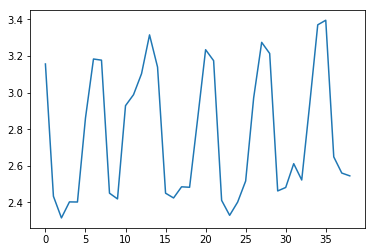

In [26]:
plt.plot(testpreds[129])

In [27]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [28]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.759211   
air_0164b9927d20bcc3_2017-04-23              1.314204   
air_0241aa3964b7f861_2017-04-23              2.396850   
air_0328696196e46f18_2017-04-23              2.154083   
air_034a3d5b40d5b1b1_2017-04-23              3.514323   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.807851  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.721785  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.988504  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.619980  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  32.593170

In [29]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [30]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [31]:
submission.to_csv("../submission/l4_3000_ridge_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')